# Review
Hi, my name is Dmitry and I will be reviewing your project.

You can find my comments in colored markdown cells:

<div class="alert alert-success">
    If everything is done succesfully.
</div>

<div class="alert alert-info">
    If I have some (optional) suggestions, or questions to think about, or general comments.
</div>

<div class="alert alert-danger">
    If a section requires some corrections. Work can't be accepted with red comments.
</div>

First of all, thank you for turning in the project! You did a very good job! The project is accepted, good luck in your future studies!

# Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

# Init

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Load Data

In [4]:
# load data

df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
# first glance, and show data dimensions

display(df_reviews.head(), df_reviews.shape)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


(47331, 17)

In [6]:
# check if there is missing values

print([var for var in df_reviews.columns if df_reviews[var].isnull().sum() > 0])

['average_rating', 'votes']


In [7]:
# locate the missing values

display(df_reviews.loc[df_reviews.votes.isna(),], df_reviews.loc[df_reviews.average_rating.isna(),])

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,NaN,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,NaN,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,NaN,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,NaN,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


In [8]:
# since there are only two records, we decided to drop them instead

df_reviews.dropna(inplace=True)
df_reviews.shape

(47329, 17)

# EDA

Let's check the number of movies and reviews over years.

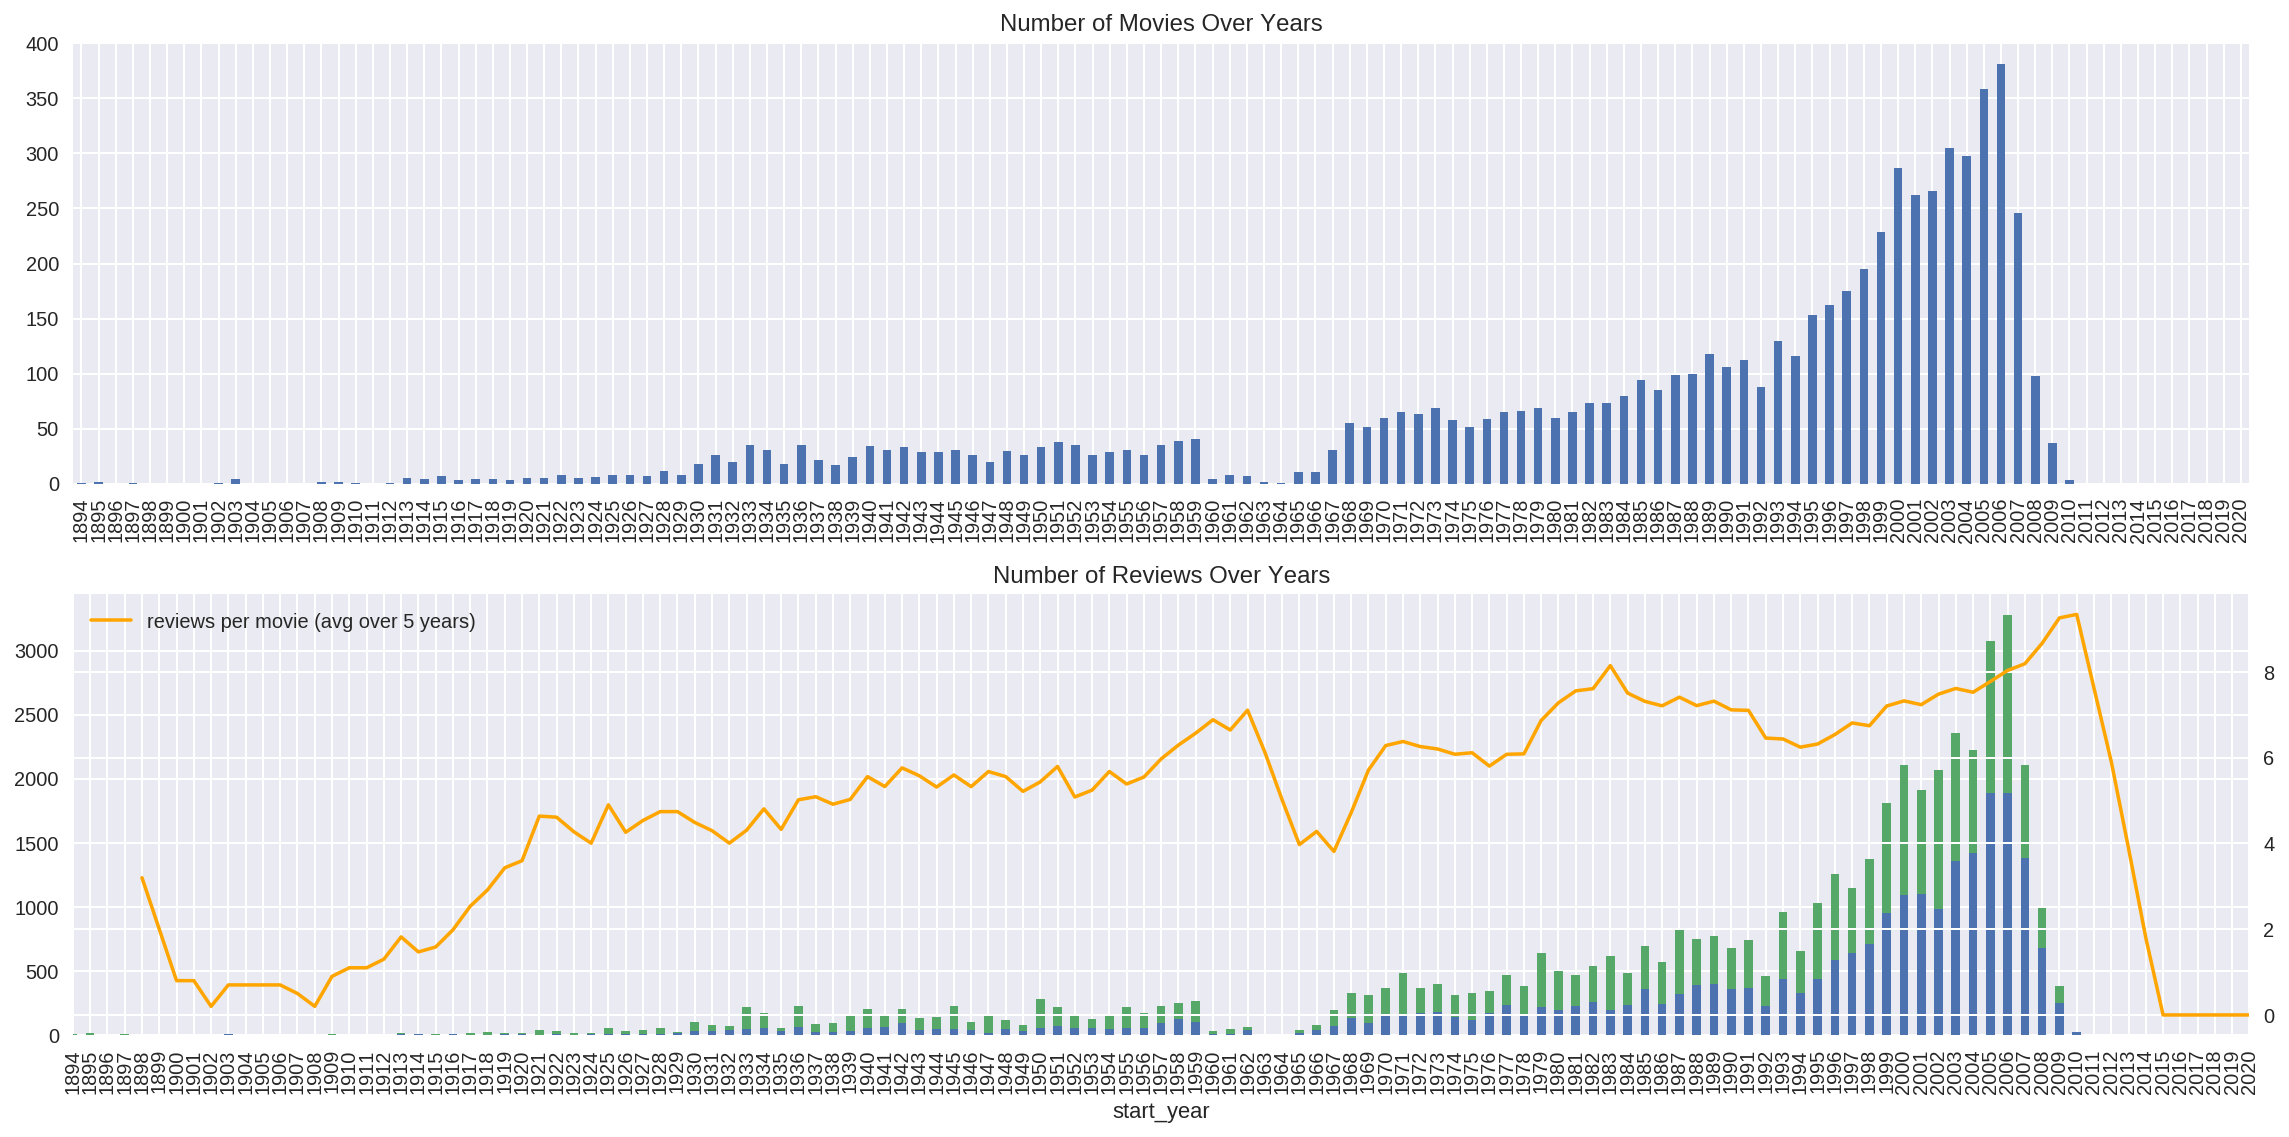

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

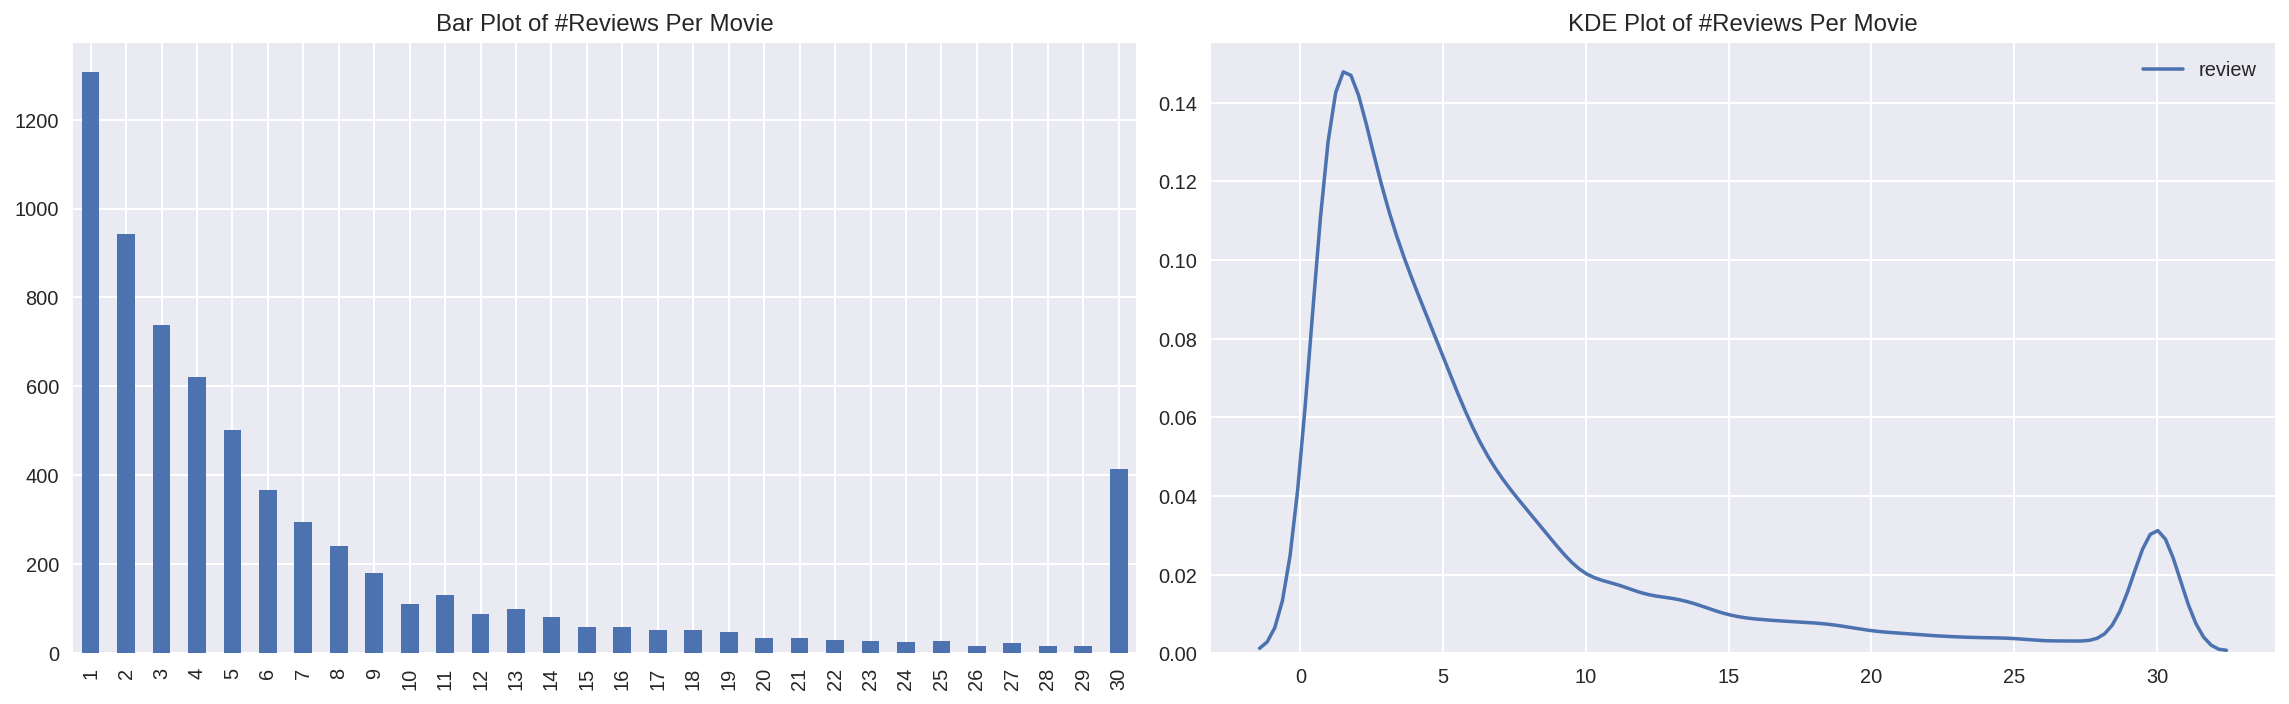

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

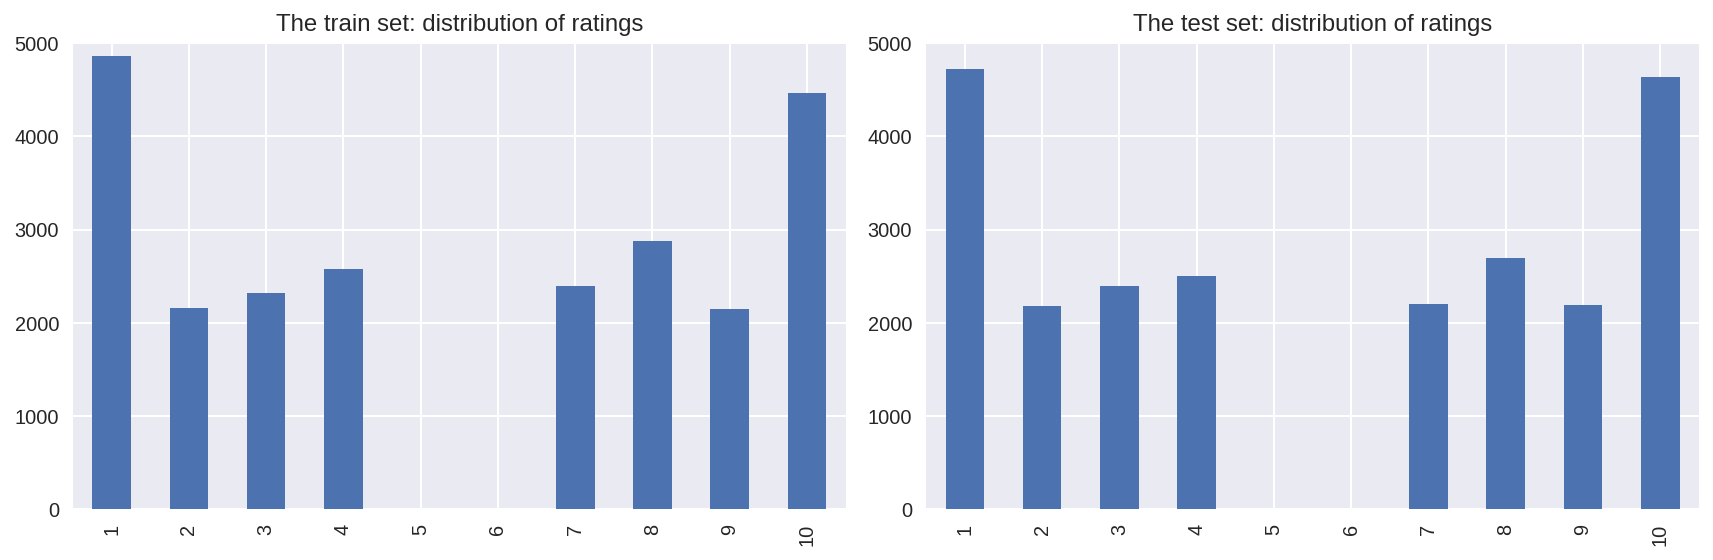

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

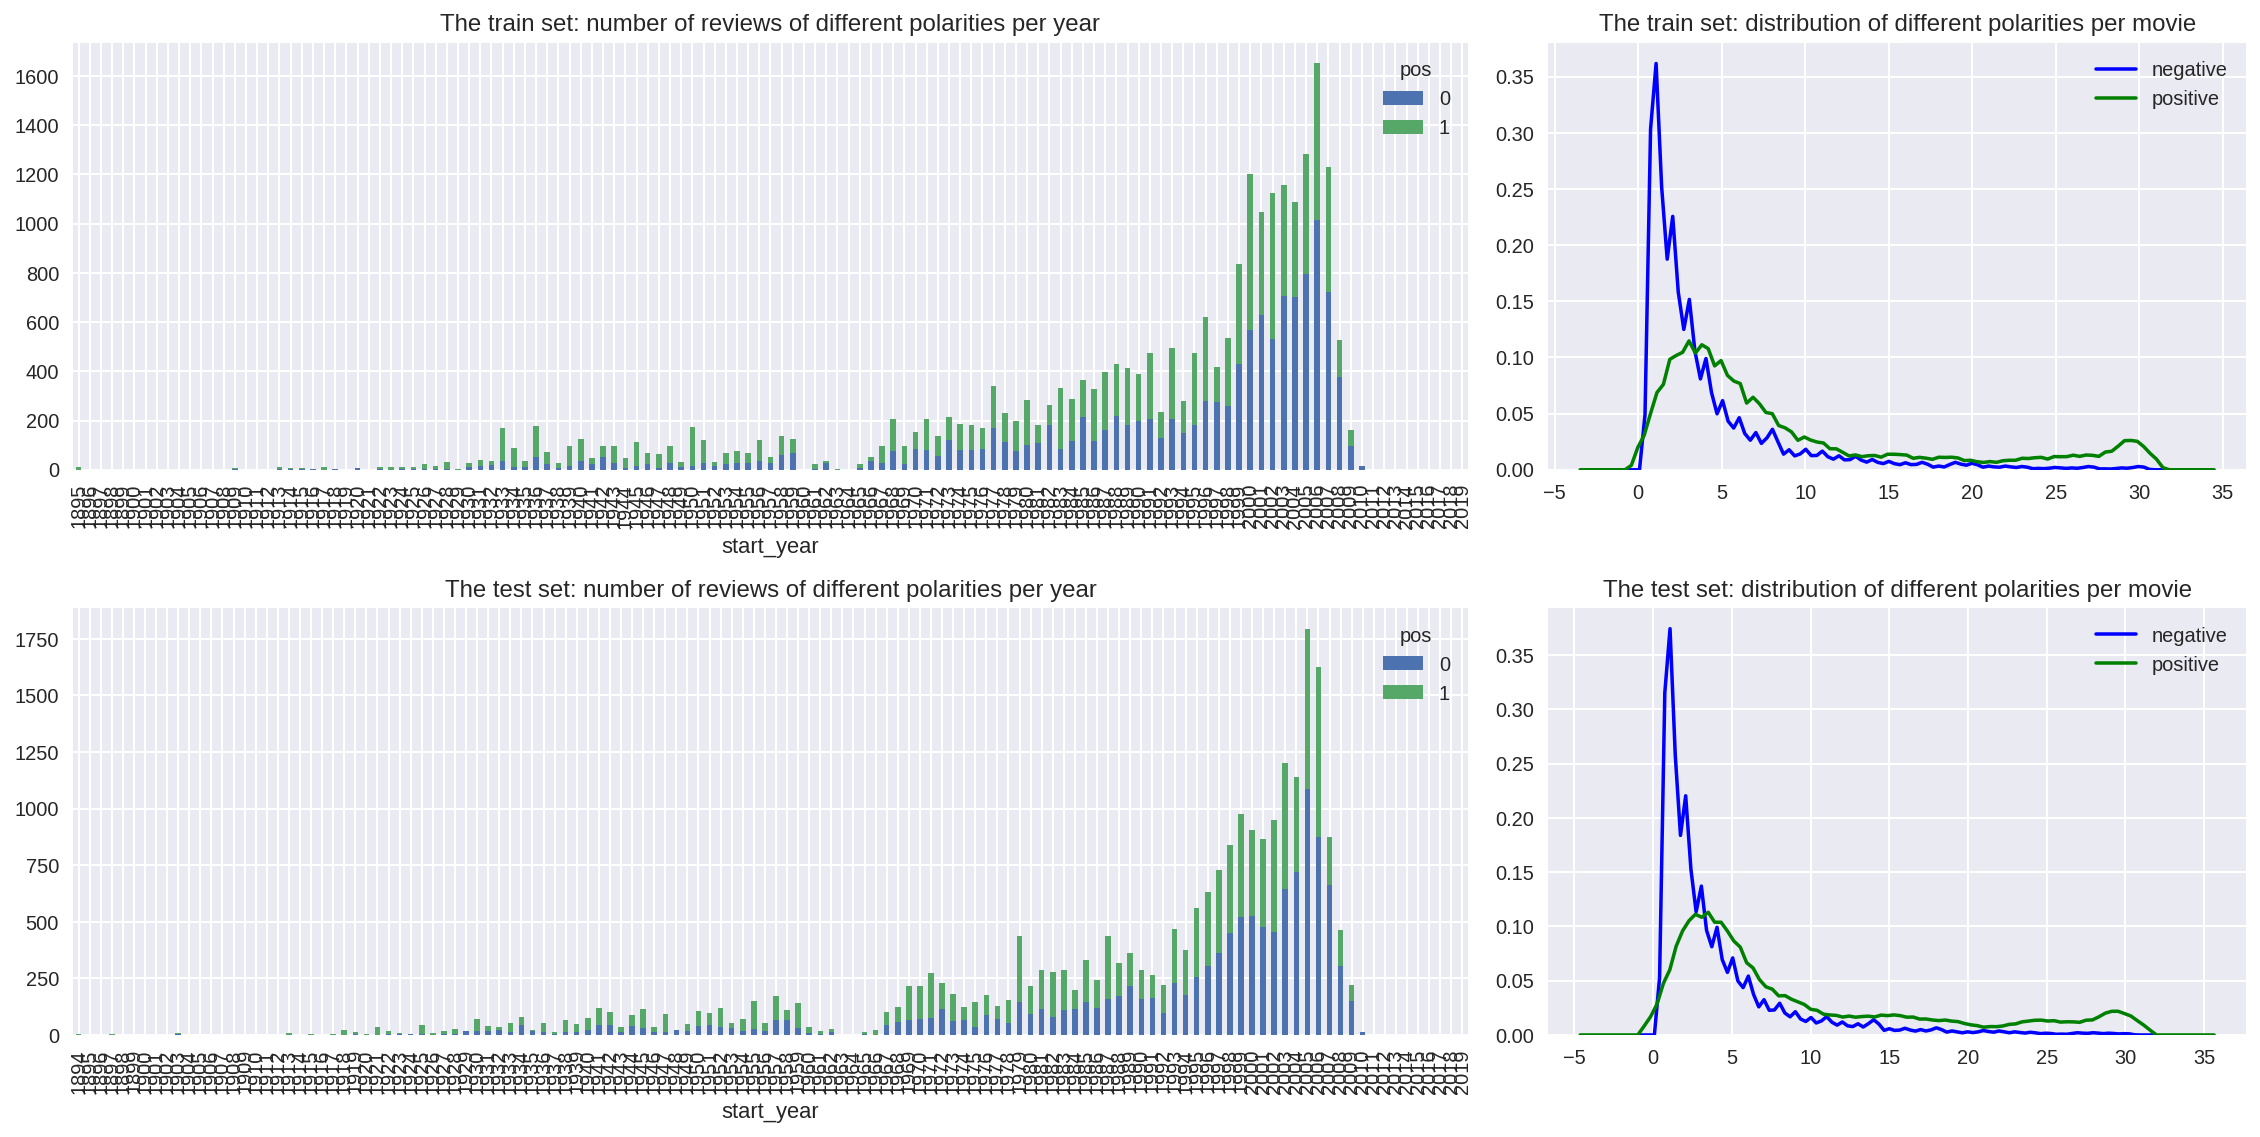

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

<div class="alert alert-info">
    Would be really cool if you added some comments on what we can see from these pretty plots
</div>

# Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [13]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

# Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [14]:
# taking this text as an example

df_reviews.review[100]

"Years ago, Sara, a young girl witnessed her parents being murdered, now as an adult she suffers from various mental ailments (did I mention she has an imaginary friend?) This film lulls the viewer, not into a sense of tension, mind you, but rather a sense of sleepiness. Deathly boring, I found it hard to sit through as I could feel my eyelids growing heavier and heavier with each endless minute of mindless prattle and supposed 'mystery'. Is Sara going crazy? or is it the paranormal? A better question would be, Who cares? And the answer to that, no one. No one at all. Skip this film, save yourself some time better suited to do other more worthwhile tasks. My Grade: D-"

In [15]:
# text preprocessing function

import re

REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

def review_to_words(review):
    words = REPLACE_NO_SPACE.sub("", review.lower())
    words = REPLACE_WITH_SPACE.sub(" ", words)
    return words

In [16]:
review_to_words(df_reviews.review[100])

'years ago sara a young girl witnessed her parents being murdered now as an adult she suffers from various mental ailments did i mention she has an imaginary friend this film lulls the viewer not into a sense of tension mind you but rather a sense of sleepiness deathly boring i found it hard to sit through as i could feel my eyelids growing heavier and heavier with each endless minute of mindless prattle and supposed mystery is sara going crazy or is it the paranormal a better question would be who cares and the answer to that no one no one at all skip this film save yourself some time better suited to do other more worthwhile tasks my grade d '

In [17]:
# perform text preprocessing then store the results to a new column

df_reviews['review_norm'] = df_reviews['review'].apply(review_to_words)

<div class="alert alert-success">
    Well done! Now the text is normalized and can be worked with
</div>

# Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [18]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


# Model 1 - Constant

In [19]:
from sklearn.dummy import DummyClassifier

In [20]:
# create a dummy classifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(df_reviews_train.review_norm, train_target)

DummyClassifier(constant=None, random_state=None, strategy='most_frequent')

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


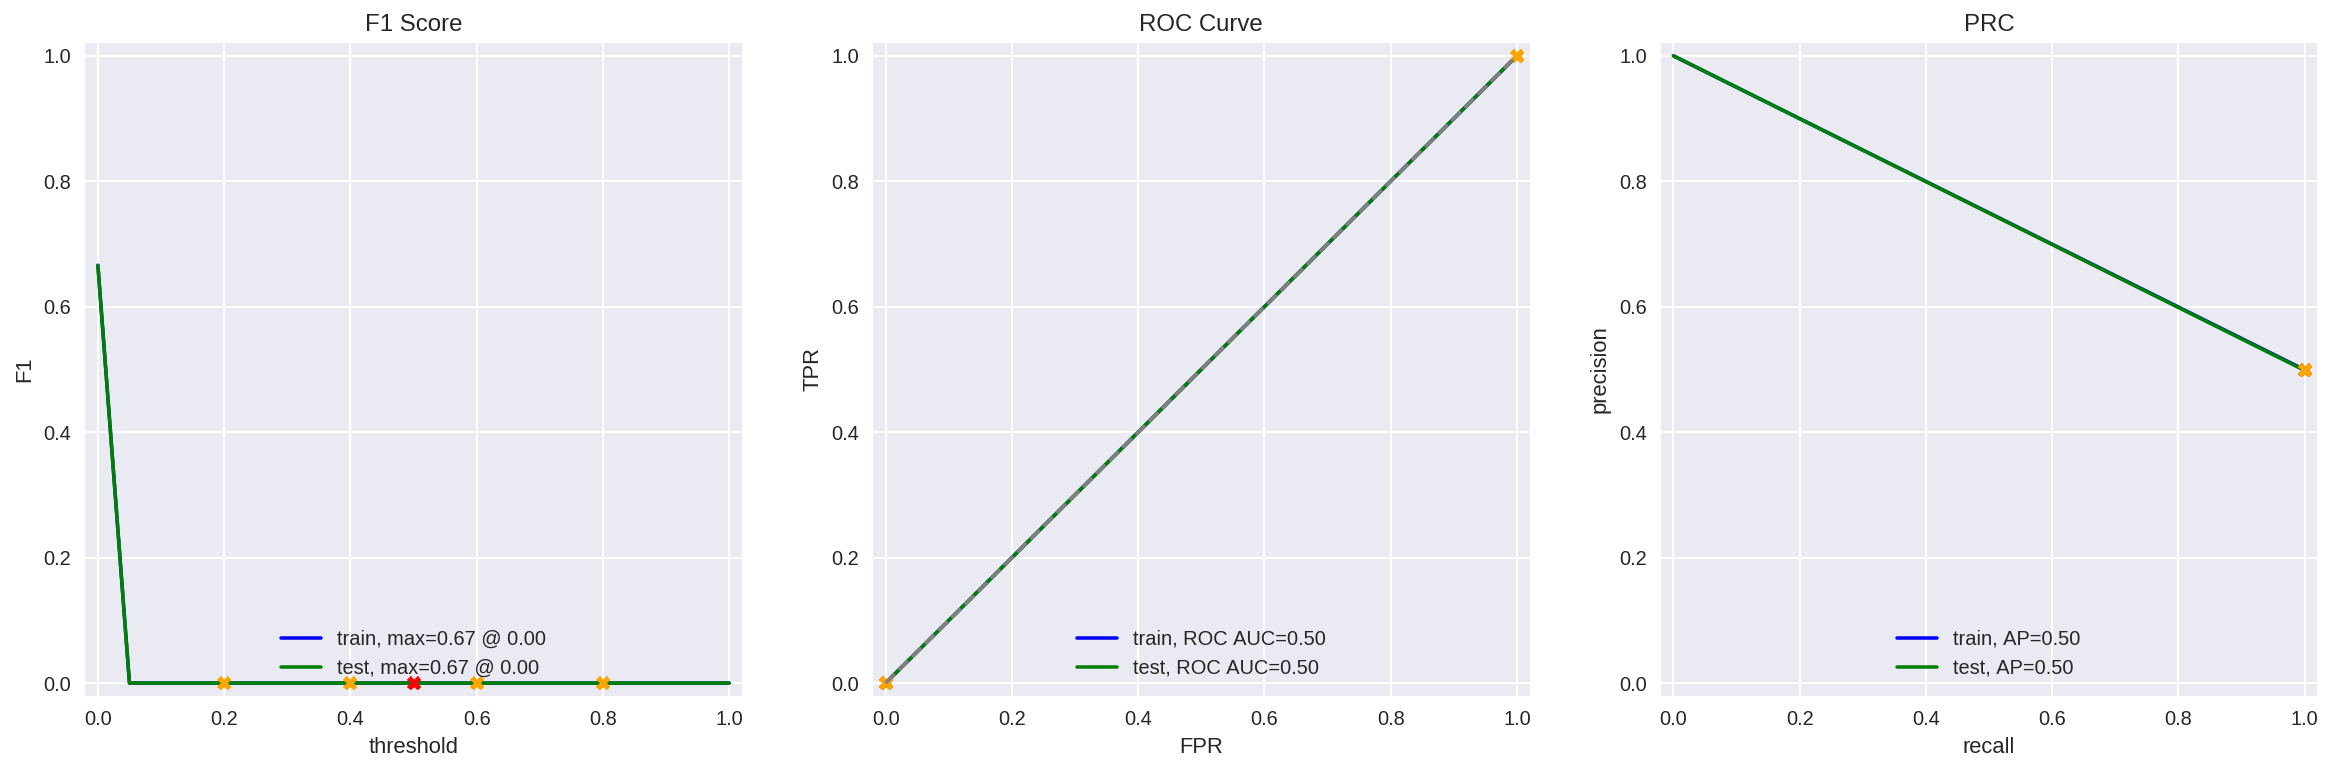

In [21]:
# the predicted results should be somewhere around 0.5 in terms of accuracy since all dummy classifier does is to randomly guess

evaluate_model(dummy_clf, df_reviews_train.review_norm, train_target, df_reviews_test.review_norm, test_target)

# Model 2 - NLTK, TF-IDF and LR

### TF-IDF

In [22]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

lemmatizer  = WordNetLemmatizer()

In [23]:
# use nltk to tokenize

df_reviews_train['review_tokens'] = df_reviews_train['review_norm'].apply(word_tokenize)
df_reviews_test['review_tokens'] = df_reviews_test['review_norm'].apply(word_tokenize)

In [24]:
# use nltk to lemmatize

def lemmatize(text):
    lemmas = [lemmatizer.lemmatize(token) for token in text]
    return ' '.join(lemmas)

df_reviews_train['review_lemmas'] = df_reviews_train['review_tokens'].apply(lemmatize)
df_reviews_test['review_lemmas'] = df_reviews_test['review_tokens'].apply(lemmatize)

In [25]:
# define corpus, remove stop words, then use tf_idf to vectorize

corpus = df_reviews_train['review_lemmas']
stop_words = set(stopwords.words('english'))
count_tf_idf_2 = TfidfVectorizer(stop_words=stop_words)
tf_idf = count_tf_idf_2.fit_transform(corpus)

In [26]:
# define a logistic regression model then train

lr = LogisticRegression().fit(tf_idf, train_target)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [27]:
# transform test feature

tf_idf_test = count_tf_idf_2.transform(df_reviews_test['review_lemmas'])

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


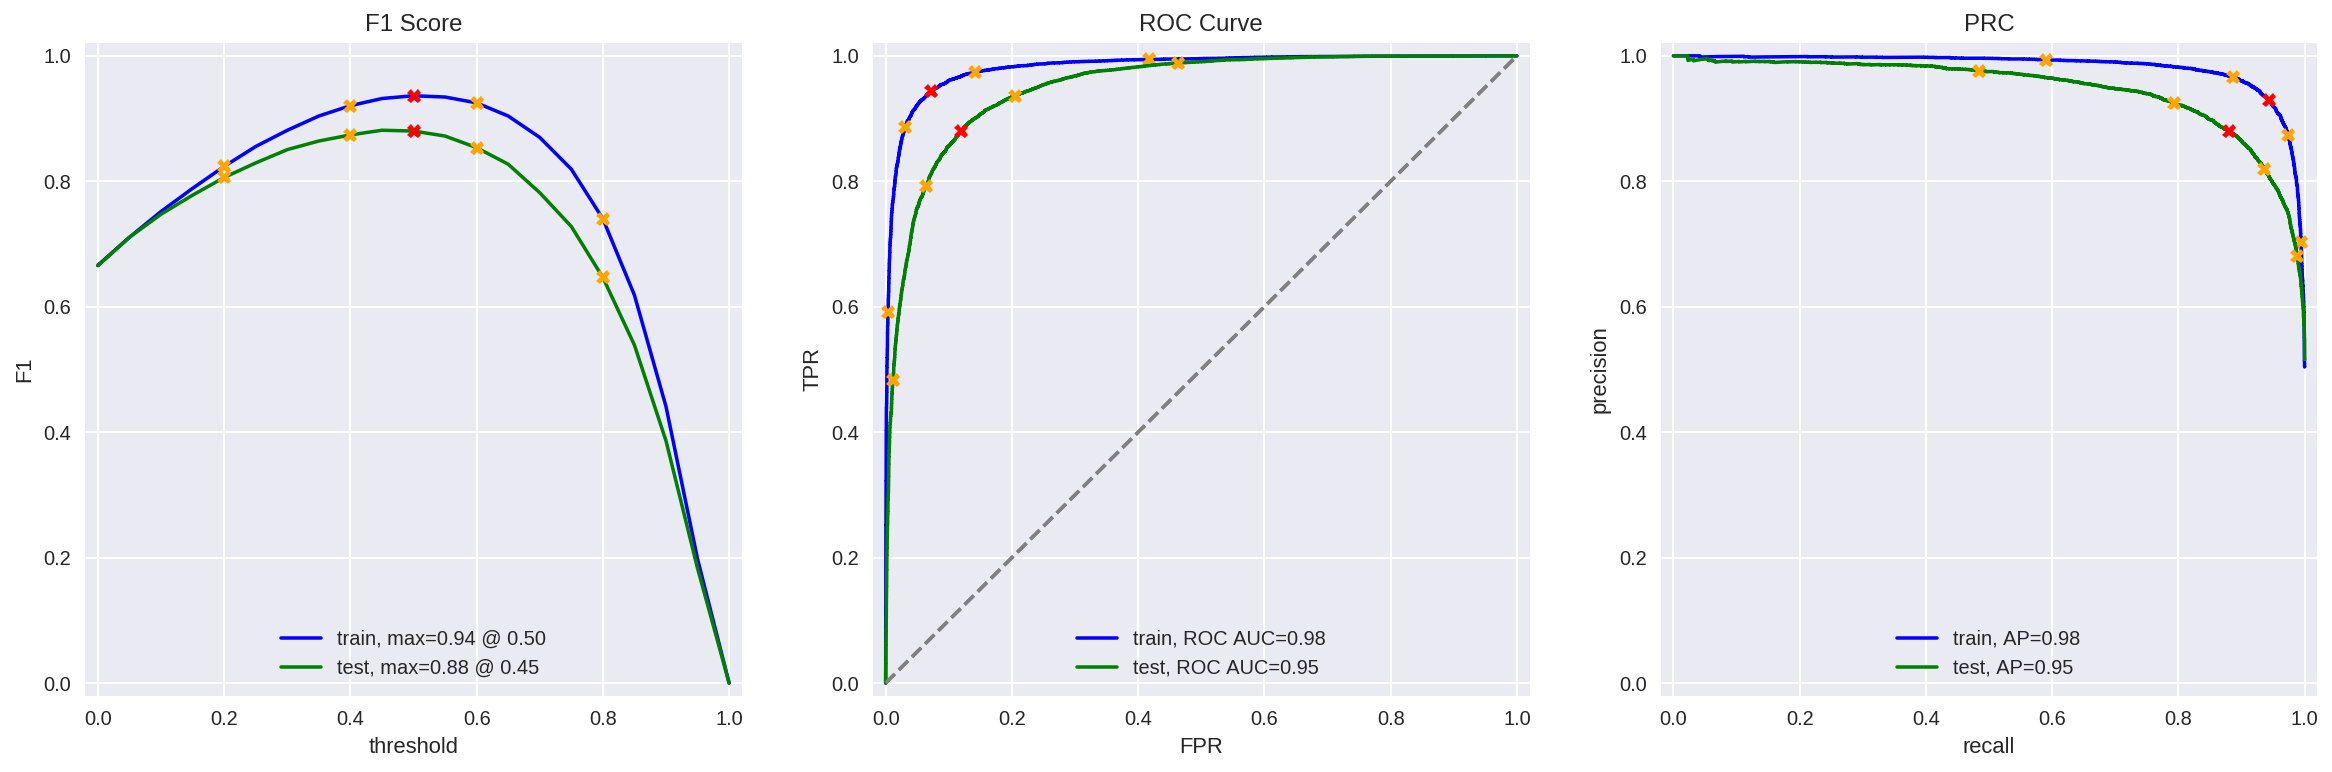

In [28]:
# evaluation

evaluate_model(lr, tf_idf, train_target, tf_idf_test, test_target)

# Model 3 - spaCy, TF-IDF and LR

In [29]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [30]:
# use spacy to tokenize and lemmatize

def text_preprocessing_3(text):
    
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    
    return ' '.join(lemmas)

df_reviews_train['review_lemmas_spacy'] = df_reviews_train['review_norm'].apply(text_preprocessing_3)
df_reviews_test['review_lemmas_spacy'] = df_reviews_test['review_norm'].apply(text_preprocessing_3)

In [31]:
# define corpus, remove stop words, then use tf_idf to vectorize

corpus = df_reviews_train['review_lemmas_spacy']
stop_words = set(stopwords.words('english'))
count_tf_idf_3 = TfidfVectorizer(stop_words=stop_words)
tf_idf_spacy = count_tf_idf_3.fit_transform(corpus)

In [32]:
# define a logistic regression model then train

lr_spacy = LogisticRegression().fit(tf_idf_spacy, train_target)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [33]:
# define test feature

tf_idf_test_spacy = count_tf_idf_3.transform(df_reviews_test['review_lemmas_spacy'])

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


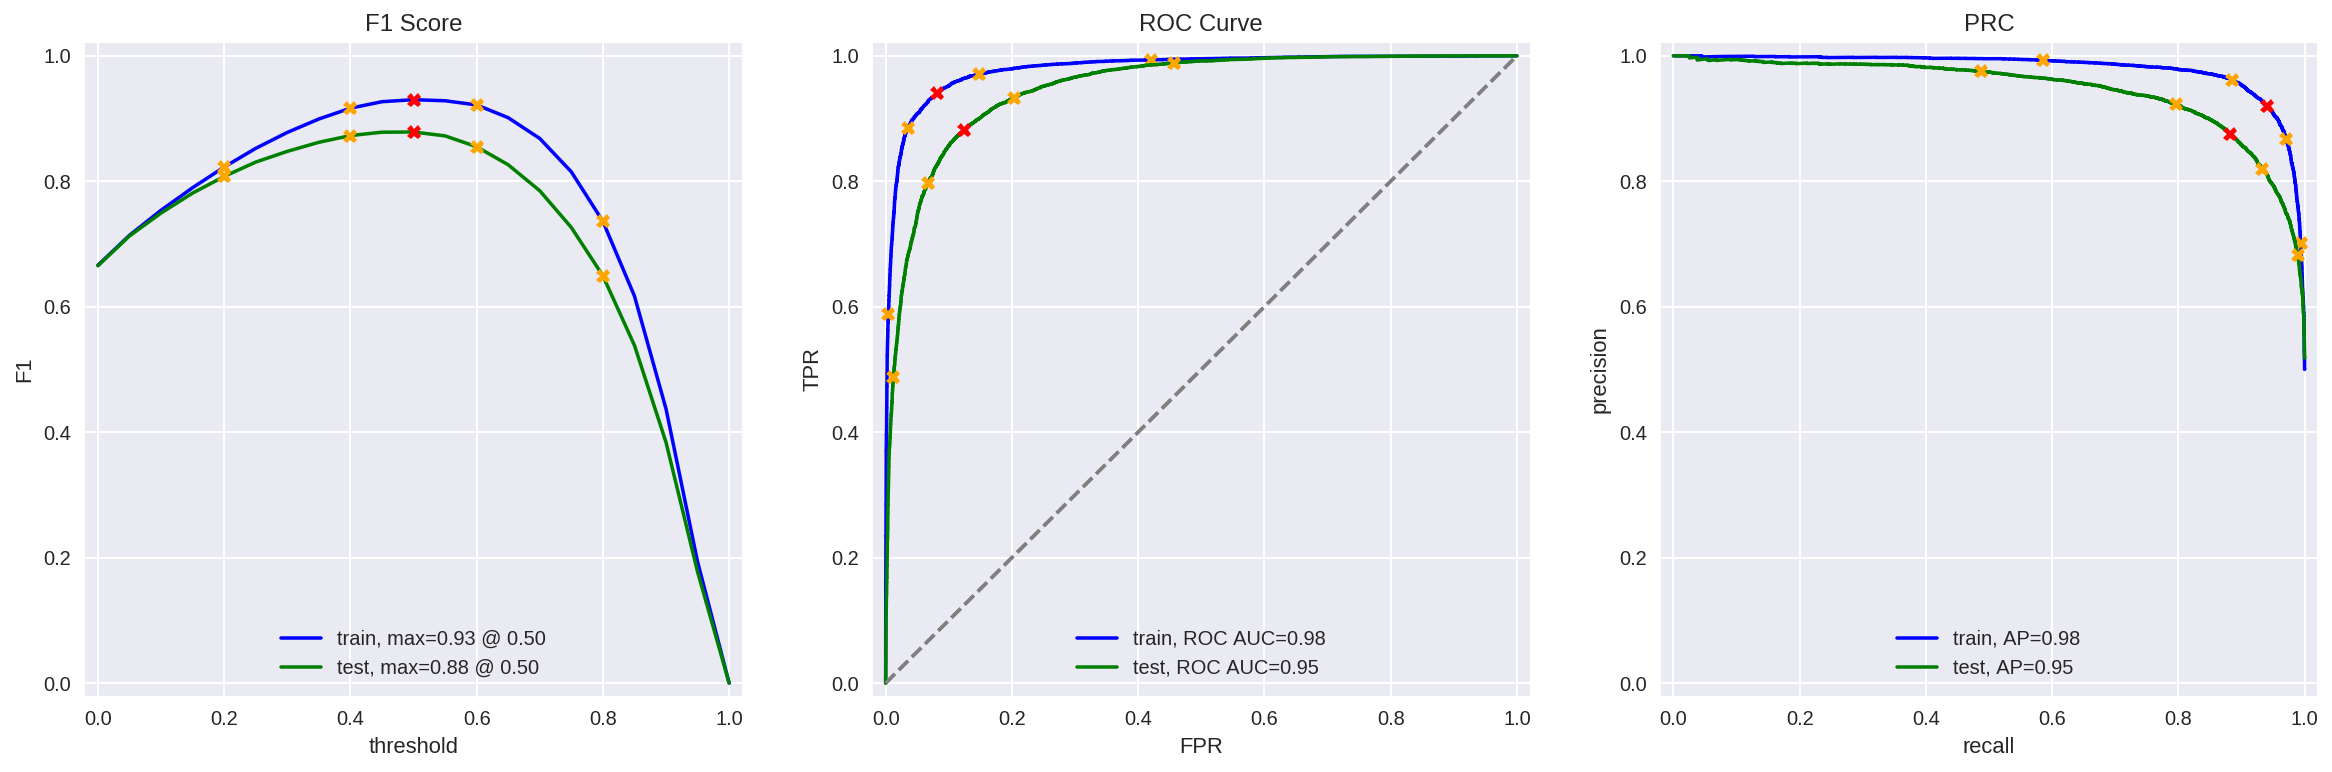

In [34]:
# evaluation

evaluate_model(lr_spacy, tf_idf_spacy, train_target, tf_idf_test_spacy, test_target)

# Model 4 - spaCy, TF-IDF and LGBMClassifier

In [35]:
from lightgbm import LGBMClassifier

In [36]:
# define a lgbm classifier and train

lgb = LGBMClassifier().fit(tf_idf_spacy, train_target)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.91  0.85
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


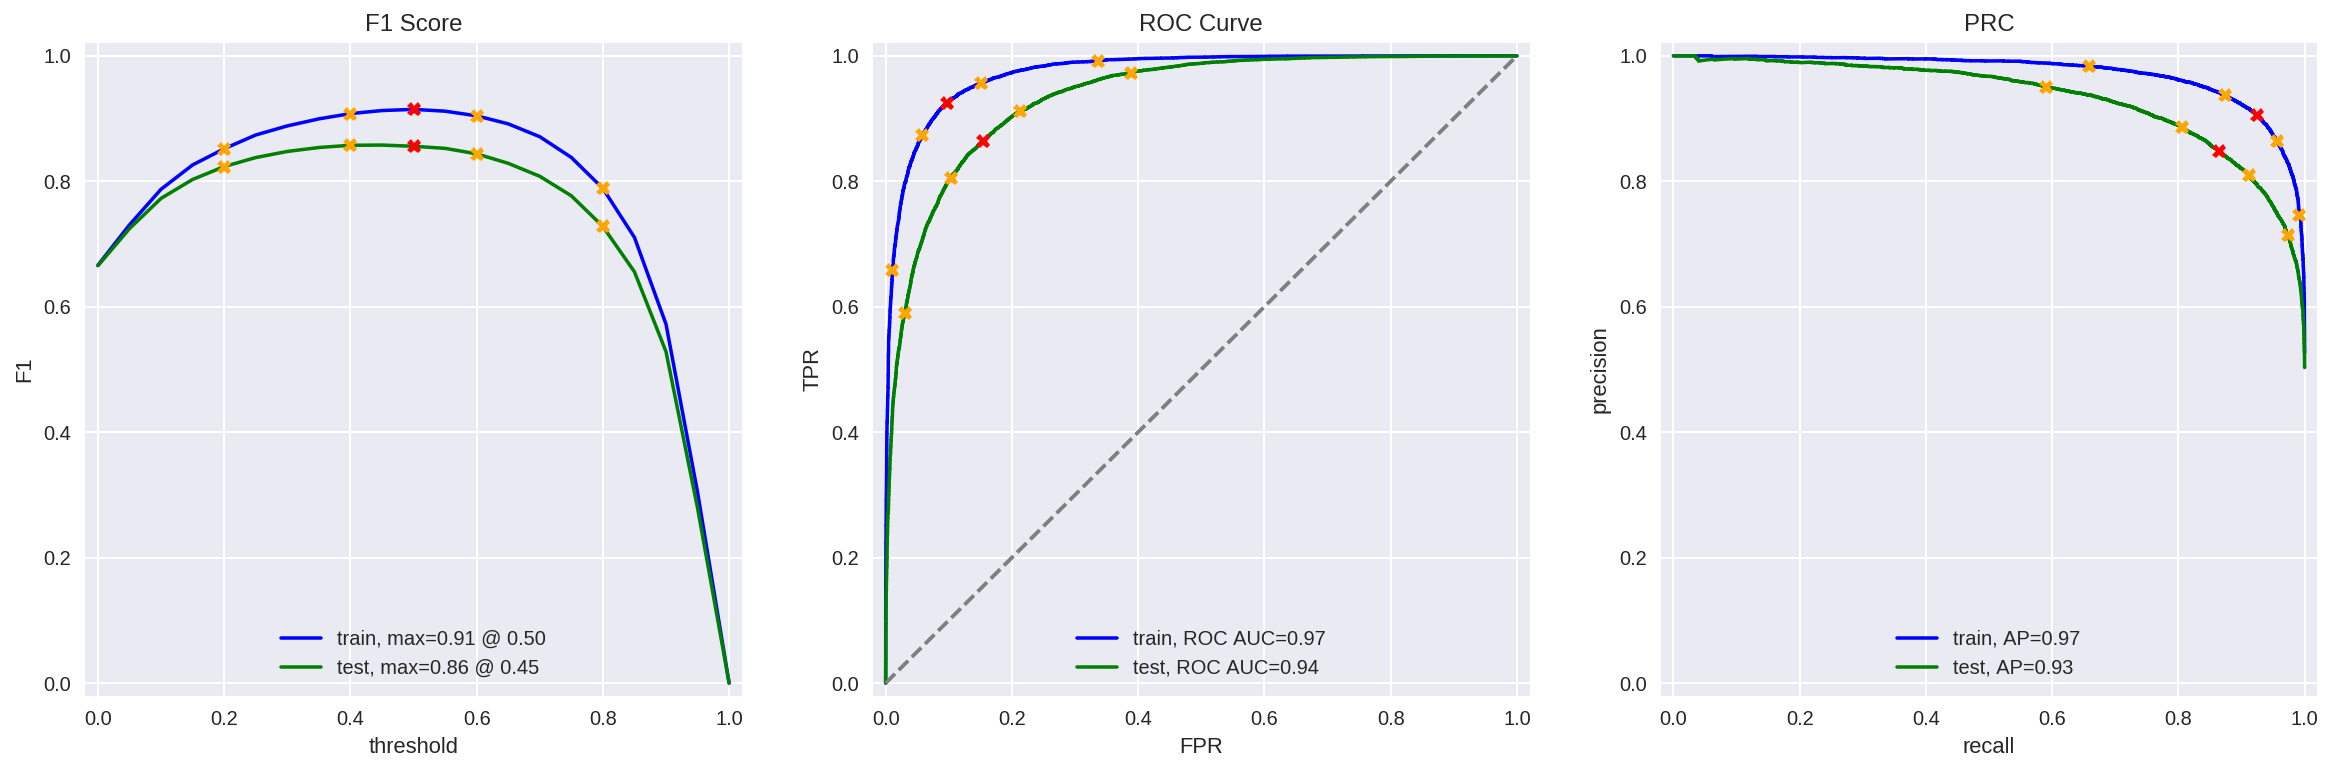

In [37]:
# evaluation

evaluate_model(lgb, tf_idf_spacy, train_target, tf_idf_test_spacy, test_target)

#  Model 9 - BERT

In [19]:
import torch
import transformers

In [20]:
# initialize BERT embedding model configuration

tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [21]:
# since it takes long to run BERT embedding, we will take a training sample and do the model training

max_sample_size = 50

In [22]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []
    tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
    
    # obtain token ids then padding and masking
    
    for input_text in texts:
        ids = tokenizer.encode(input_text, add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    
    
    # register processing unit
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    
    # gettings embeddings in batches
    
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [23]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours

train_features_9 = BERT_text_to_embeddings(df_reviews_train.iloc[:max_sample_size]['review_norm'], 
                                           max_length=512, batch_size=100, force_device='cpu')

Using the cpu device.


In [24]:
# BERT embedding for the test set

test_features_9 = BERT_text_to_embeddings(df_reviews_test.iloc[:max_sample_size]['review_norm'], 
                                           max_length=512, batch_size=100, force_device='cpu')

Using the cpu device.


In [26]:
print(train_features_9.shape)
print(test_features_9.shape)

(23796,)
(50, 768)
(50, 768)


In [27]:
# if you have got the embeddings, it's advisable to save them to have them ready
np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

In [28]:
test_features_9

array([[-0.03845888, -0.34133765,  0.2886249 , ..., -0.9468179 ,
         0.60986495,  0.38255635],
       [-0.4596234 , -0.11028501,  0.5150452 , ..., -0.71873885,
         0.79547364, -0.39839163],
       [-0.56054103, -0.16949011,  0.5735219 , ..., -1.0221192 ,
         0.7703792 , -0.44491154],
       ...,
       [-0.4443288 , -0.10875698,  0.21457334, ..., -0.7010189 ,
         0.6899959 , -0.3789833 ],
       [ 0.01028703,  0.08827008,  0.5161327 , ..., -0.47560996,
         0.7346897 , -0.15560596],
       [-0.18940507,  0.11840902,  0.2437831 , ..., -0.35319257,
         0.4999102 , -0.23253313]], dtype=float32)

# My Reviews

In [38]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(review_to_words)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didnt expect the reboot to be so good writer...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move & i real...


## Model 2

In [39]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = lr.predict_proba(count_tf_idf_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.18:  i did not simply like it not my kind of movie
0.19:  well i was bored and felt asleep in the middle of the movie
0.59:  i was really fascinated with the movie
0.18:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.31:  i didnt expect the reboot to be so good writers really cared about the source material
0.52:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.08:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.89:  launching on netflix was a brave move & i really appreciate being able to binge on episode after epi


## Model 3

In [40]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = lr_spacy.predict_proba(count_tf_idf_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.27:  i did not simply like it not my kind of movie
0.08:  well i was bored and felt asleep in the middle of the movie
0.44:  i was really fascinated with the movie
0.10:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.24:  i didnt expect the reboot to be so good writers really cared about the source material
0.53:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.02:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.91:  launching on netflix was a brave move & i really appreciate being able to binge on episode after epi


## Model 4

In [41]:
texts = my_reviews['review_norm']

count_tf_idf_4 = count_tf_idf_3
my_reviews_pred_prob = lgb.predict_proba(count_tf_idf_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.64:  i did not simply like it not my kind of movie
0.32:  well i was bored and felt asleep in the middle of the movie
0.62:  i was really fascinated with the movie
0.35:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.69:  i didnt expect the reboot to be so good writers really cared about the source material
0.67:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.27:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.80:  launching on netflix was a brave move & i really appreciate being able to binge on episode after epi


## Model 9

In [ ]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

# Conclusions

Model 2 Conclusions (NLTK, TF-IDF and LR):
- Text after being tokenized and lemmatized with NLTK, then vectorized appear to have the highest scores here. 
- The logistic regression model was able to achieve a 0.88 accuracy on the test sets.

Model 3 Conclusions (spaCy, TF-IDF and LR):
- Text passed to a logistic regression model after being processed with the spaCy package are predicted to have similar results as the previous modeling results. We can conclude that using the spaCy package to preprocess text does not improve modeling scores on the test set.
- The logistic regression model (used spaCy preprocessing) was able to achieve a 0.88 accuracy on the test set. 

Model 4 Conclusions (spaCy, TF-IDF and LGBMClassifier):
- The same text (being preprocessed with spaCy) passed to a LGBMClassifier model shows to have inferior results comparing to the logistic regression modeling results; only achieved a 0.85 accuracy on the test set.
- Observing the modeling performance using "my_reviews" feature set, we see that the same text would have much higher predicted probability then if it were being learned by a logistic regression model. 
- For example, the first text from the "my_reviews" feature set is predicted to have a 0.64 probability. Making it highly likely to be predicted as a positive review. However, the same text resulted from the logistic regression model has a probability score of 0.18 and 0.27 (depends on using either NLTK or spaCy), which indicates that this text should actually being predicted as a negative review.

<div class="alert alert-success">
    Very good! You successfully completed the tasks: the train and test sets are used correctly, tf-idf doesn't see the test set during fitting, there is a baseline, and the required threshold is reached. Thanks for adding detailed conclusions!
</div>

# Check List

- [x]  Notebook was opened
- [x]  The text data is loaded and pre-processed for vectorization
- [x]  The text data is transformed to vectors
- [x]  Models are trained and tested
- [x]  The metric's threshold is reached
- [x]  All the code cells are arranged in the order of their execution
- [x]  All the code cells can be executed without errors
- [x]  There are conclusions